In [6]:
from image_ocr import extract_text
from image_vector import read_img, reduce_dimensionality, load_model
import torch
import numpy as np
import pickle
import time
import cv2
import re
import os
import easyocr
from sklearn.metrics.pairwise import cosine_similarity
from ocr_netvlad import load_image_labels,get_image_point,find_most_similar_images

In [22]:
if __name__ == '__main__':

    start_time = time.time()

    weight_path = 'pretrain-model.pth.tar'
    cuda = torch.cuda.is_available()
    model = load_model(weight_path, cuda)
    reader = easyocr.Reader(['ko', 'en'])

    labels = load_image_labels('image_label.txt')
    label2 = load_image_labels('image_test_label.txt')

    target_image = 'test/test(64).jpg'
    target_image2 = target_image.replace('test/', '')
    point = get_image_point(target_image2, label2)
    print(f"'{target_image}'의 포인트 값: {point}")

    print()
    r = find_most_similar_images(target_image, model,reader,labels, top_k=5, ocr_data='reduced_ocr_text_index.pkl', pca_path='pca_model.pkl', data_path='reduced_image_vectors_list.pkl', cuda=cuda)
    total_time = time.time() - start_time
    print(r)
    print(f"Total execution time: {total_time:.4f} seconds")

c:\Users\jin03\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jin03\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


'test/test(64).jpg'의 포인트 값: (0.0, 27.54, 3.0)

층 구별 실패 및 OCR 성공, 전체 이미지에서 OCR,유사도 계산
[('3F_day(51).jpg', 0.840266242115908, (0.0, 23.94, 3.0), 2)]
Total execution time: 3.3250 seconds


In [ ]:
if __name__ == '__main__':

    start_time = time.time()

    weight_path = 'pretrain-model.pth.tar'
    cuda = torch.cuda.is_available()
    model = load_model(weight_path, cuda)
    reader = easyocr.Reader(['ko', 'en'])

    labels = load_image_labels('image_label.txt')
    label2 = load_image_labels('image_test_label.txt')

    # test_image 폴더 내 모든 이미지 파일 가져오기
    image_folder = 'test'
    image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg'))] 

    for image_file in image_files:
        target_image = os.path.join(image_folder, image_file)
        target_image2 = image_file  
        point = get_image_point(target_image2, label2)
        print(f"'{target_image2}'의 포인트 값: {point}")

        # find_most_similar_images 함수 호출
        find_most_similar_images(target_image, model, reader, labels, top_k=2, ocr_data='ocr_text_index.pkl', pca_path='pca_model.pkl', data_path='reduced_image_vectors_list.pkl', cuda=cuda)

    total_time = time.time() - start_time
    print(f"Total execution time: {total_time:.4f} seconds")


In [ ]:
import os
import time
import torch
import easyocr

def get_floor_from_point(point):
    """포인트 값에서 층수를 결정하는 함수"""
    if point == 2:  
        return "2F"
    elif point == 3: 
        return "3F"
    else:
        return None

if __name__ == '__main__':

    start_time = time.time()

    weight_path = 'pretrain-model.pth.tar'
    cuda = torch.cuda.is_available()
    model = load_model(weight_path, cuda)
    reader = easyocr.Reader(['ko', 'en'])

    labels = load_image_labels('image_label.txt')
    label2 = load_image_labels('image_test_label.txt')

    test_folder = 'test'  
    test_images = [f for f in os.listdir(test_folder) if f.endswith('.jpg')]  

    correct_total = 0
    correct_2F = 0
    correct_3F = 0
    total_count = 0
    count_2F = 0
    count_3F = 0
    correct_no_floor = 0
    floor_correct = 0

    for test_image in test_images:
        # 각 이미지에 대한 포인트 값 및 유사도 계산
        target_image_path = os.path.join(test_folder, test_image)
        target_image_name = test_image
        point = get_image_point(target_image_name, label2)
        floor = get_floor_from_point(point[2])  # 포인트 값으로 층수 추출
        print(f"\n'{target_image_name}'의 포인트 값: {point}, 층수: {floor}")

        # 유사한 이미지 검색
        most_similar_images = find_most_similar_images(
            target_image_path, model, reader, labels, top_k=1, 
            ocr_data='reduced_ocr_text_index.pkl', pca_path='pca_model.pkl', 
            data_path='reduced_image_vectors_list.pkl', cuda=cuda
        )

        for image_name, similarity, image_point, _ in most_similar_images:
            # 전체 적중률 계산
            total_count += 1
            if image_point == point:
                print('적중')
                correct_total += 1
            else :
                print('실패')
            
            if ((image_point[0] == point[0])and (image_point[1] == point[1])):
                print('좌표 적중')
                correct_no_floor += 1
            else :
                print('실패')

            if (image_point[2] == point[2]):
                print('층 적중')
                floor_correct += 1
            else :
                print('실패')

            print(image_name, image_point)
            # 층별 적중률 계산
            predicted_floor = get_floor_from_point(image_point[2])
            if predicted_floor == "2F":
                count_2F += 1
                if image_point == point:
                    correct_2F += 1
            elif predicted_floor == "3F":
                count_3F += 1
                if image_point == point:
                    correct_3F += 1

    # 전체 적중률 계산
    total_accuracy = correct_total / total_count if total_count > 0 else 0
    print(f"\n전체 적중률: {total_accuracy:.2%}")

    # 좌표 적중률 계산
    nofloor_accuracy = correct_no_floor / total_count if total_count > 0 else 0
    print(f"\n좌표 적중률: {nofloor_accuracy:.2%}")

    # 층 적중률 계산
    floor_accuracy = floor_correct / total_count if total_count > 0 else 0
    print(f"\n층 적중률: {floor_accuracy:.2%}")

    # 2층 적중률 계산
    accuracy_2F = correct_2F / count_2F if count_2F > 0 else 0
    print(f"2층 적중률: {accuracy_2F:.2%}")

    # 3층 적중률 계산
    accuracy_3F = correct_3F / count_3F if count_3F > 0 else 0
    print(f"3층 적중률: {accuracy_3F:.2%}")

    total_time = time.time() - start_time
    print(f"Total execution time: {total_time:.4f} seconds")


c:\Users\jin03\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jin03\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



'test(1).jpg'의 포인트 값: (0.0, 0.0, 2.0), 층수: 2F
층 구별 및 OCR 모두 실패, 전체 이미지에서 유사도 계산
실패
좌표 적중
실패
3F_night(12).jpg (0.0, 0.0, 3.0)

'test(10).jpg'의 포인트 값: (0.0, 27.54, 2.0), 층수: 2F
OCR로 매칭된 이미지 존재, 코사인 유사도 계산 시작
실패
실패
층 적중
2F_day(53).jpg (0.0, 23.94, 2.0)

'test(100).jpg'의 포인트 값: (29.52, 47.88, 3.0), 층수: 3F
OCR로 매칭된 이미지 존재, 코사인 유사도 계산 시작
적중
좌표 적중
층 적중
3F_night(309).jpg (29.52, 47.88, 3.0)

'test(101).jpg'의 포인트 값: (29.52, 47.88, 3.0), 층수: 3F
OCR로 매칭된 이미지 존재, 코사인 유사도 계산 시작
실패
실패
층 적중
3F_day(261).jpg (31.68, 34.92, 3.0)

'test(102).jpg'의 포인트 값: (29.52, 47.88, 3.0), 층수: 3F
층 구별 실패 및 OCR 성공, 전체 이미지에서 OCR,유사도 계산
실패
실패
실패
2F(71).jpg (30.6, 40.32, 2.0)

'test(103).jpg'의 포인트 값: (28.08, 55.8, 3.0), 층수: 3F
OCR로 매칭된 이미지 존재, 코사인 유사도 계산 시작
적중
좌표 적중
층 적중
3F(81).jpg (28.08, 55.8, 3.0)

'test(104).jpg'의 포인트 값: (28.08, 55.8, 3.0), 층수: 3F
OCR로 매칭된 이미지 존재, 코사인 유사도 계산 시작
적중
좌표 적중
층 적중
3F_night(332).jpg (28.08, 55.8, 3.0)

'test(105).jpg'의 포인트 값: (28.08, 55.8, 3.0), 층수: 3F
층 구별 및 OCR 모두 실패, 전체 이미지에서 유사도 계산
실패
실패

In [15]:
#ocr_data='ocr_text_index.pkl'
#with open(ocr_data, 'rb') as f:
#    ocr_index = pickle.load(f)
#print(len(ocr_index.keys()))

ocr_data='reduced_ocr_text_index.pkl'
with open(ocr_data, 'rb') as f:
    ocr_index = pickle.load(f)
#print((ocr_index))

filtered_ocr_index = {key: value for key, value in ocr_index.items() if len(value) >= 20}
print(len(filtered_ocr_index.keys()))
print(ocr_index.get('Information'))
filtered_ocr_index.keys()

12
['2F(33).jpg', '2F_day(129).jpg', '2F_day(130).jpg', '2F_day(136).jpg', '2F_day(137).jpg', '2F_day(140).jpg', '2F_day(142).jpg', '2F_night(122).jpg', '2F_night(131).jpg', '2F_night(134).jpg', '3F(34).jpg', '3F(37).jpg']


dict_keys(['미세요', 'PUSH', '고정문', '세중공동캠퍼스', 'CARD', '강의실', '3F', '소화기', '2', '1', '연구실', 'SW'])

In [ ]:
ocr_data='reduced_image_vectors_list.pkl'
with open(ocr_data, 'rb') as f:
    saved_vectors = pickle.load(f)
vectors = np.array([item[1] for item in saved_vectors])
saved_vectors

[([[1112, 1085], [1190, 1085], [1190, 1130], [1112, 1130]],
  '313',
  0.9999834818945785),
 ([[1384, 1080], [1527, 1080], [1527, 1125], [1384, 1125]],
  '세정공동캠어스',
  0.04875280659944056),
 ([[1149, 1174], [1485, 1174], [1485, 1276], [1149, 1276]],
  'A 대학원',
  0.9044965338492581),
 ([[261, 1312], [457, 1312], [457, 1386], [261, 1386]],
  '미세요',
  0.9998392253276236),
 ([[1196, 1272], [1435, 1272], [1435, 1375], [1196, 1375]],
  '강의실',
  0.9985120031081536),
 ([[1105, 1373], [1529, 1373], [1529, 1416], [1105, 1416]],
  'NGiadae ShoolLeclure Room',
  0.3266161615793293),
 ([[288, 1400], [439, 1400], [439, 1456], [288, 1456]],
  'PUSH',
  0.9999599625821322)]

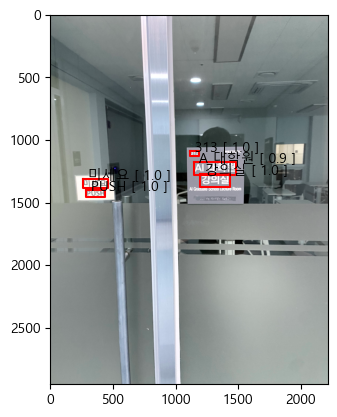

In [5]:
import cv2 
import easyocr 
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 한글 폰트 설정 (예: 나눔고딕)
font_path = "C:/Windows/Fonts/malgun.ttf"  # 또는 사용할 폰트의 경로
fontprop = font_manager.FontProperties(fname=font_path)
rc('font', family=fontprop.get_name())

query_image_name = 'test/test(73).jpg' 
#query_image_name = 'image_data/2F(73).jpg' 
# 이것은 모델을 메모리에 로드하기 위해 한 번만 실행하면 됩니다
reader = easyocr.Reader([ 'ko','en' ]) 

# 이미지 읽기
img = cv2.imread(query_image_name) 

# OCR 실행
results = reader.readtext(img) 

# 이미지를 표시하고 결과를 플로팅합니다
plt.imshow(img) 
for res in results: 
    # 감지된 텍스트의 bbox 좌표
    xy = res[ 0 ] 
    xy1, xy2, xy3, xy4 = xy[ 0 ], xy[ 1 ], xy[ 2 ], xy[ 3 ] 
    # 텍스트 결과 및 감지 신뢰도
    det, conf = res[ 1 ], res[ 2 ] 
    if conf >= 0.5:
        plt.plot([xy1[0], xy2[0], xy3[0], xy4[0], xy1[0]], [xy1[1], xy2[1], xy3[1], xy4[1], xy1[1]], 'r-')
        plt.text(xy1[0], xy1[1], f' {det} [ {round(conf, 2)} ]')

results

In [1]:
def find_most_similar_images(target_image_path, model, labels, top_k=10, pca_path='pca_model.pkl', data_path='reduced_image_vectors_list.pkl', cuda=False):
    with open(pca_path, 'rb') as f:
        pca = pickle.load(f)
    with open(data_path, 'rb') as f:
        saved_vectors = pickle.load(f)

    # 쿼리 이미지의 NetVLAD 벡터 생성
    target_image_vector = model.pool(model.encoder(read_img(target_image_path, cuda)))
    target_image_vector = target_image_vector.cpu().detach().numpy().flatten()
    target_image_vector = reduce_dimensionality([target_image_vector], pca_path=pca_path, train_pca=False)[0]

    # 전체 데이터베이스 이미지와 유사도 계산
    image_names = [item[0] for item in saved_vectors]
    vectors = np.array([item[1] for item in saved_vectors])
    similarities = cosine_similarity([target_image_vector], vectors)[0]

    # 유사도가 높은 순서로 정렬
    most_similar_indices = np.argsort(similarities)[-top_k:][::-1]
    most_similar_images = [(image_names[i], similarities[i], labels.get(image_names[i], "N/A")) for i in most_similar_indices]

    # 결과 반환
    return most_similar_images